<a href="https://colab.research.google.com/github/VesleAnne/Generative_bot/blob/main/T5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install peft -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.9/190.9 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.1/290.1 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 18.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━

In [2]:
!pip install transformers[torch] -q

In [3]:
import os
import torch
from transformers import get_linear_schedule_with_warmup, TrainingArguments, Trainer
from transformers import T5ForConditionalGeneration, T5Tokenizer, AutoModelForCausalLM
from torch.utils.data import Dataset, DataLoader, random_split
from peft import get_peft_model, PeftConfig, PeftModel, LoraConfig, get_peft_model_state_dict, prepare_model_for_int8_training, set_peft_model_state_dict
from transformers import AdamW, get_scheduler,TrainerCallback
from sklearn.model_selection import train_test_split

import torch.nn as nn

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt

In [4]:
from typing import List
from transformers import DataCollatorForSeq2Seq

In [5]:
max_length = 512

In [6]:
base_model = 'google/flan-t5-base'

In [7]:
batch_size = 6

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [9]:
# Загрузка данных из CSV файла
df = pd.read_csv('/content/drive/MyDrive/МФТИ/nlp2/chatbot/Data/Barney2.csv')
df.head(5)

,name,text,context
0,Barney,"(on the phone) hey, so you know how I've alwa...",What was I doing? Your Uncle Marshall was tak...
1,Barney,"Okay, meet me at the bar in fifteen minutes, ...","Hey, you wanna do something tonight? Hey."
2,Barney,Where's your suit!? Just once when I say suit...,Hey. I did that one time.
3,Barney,It was a blazer!,"I did that one time. You know, ever since co..."
4,Barney,I see what this is about. Have you forgotten ...,"You know, ever since college it's been Marsha..."


In [10]:
# Инициализация токенизатора
tokenizer = T5Tokenizer.from_pretrained(base_model)
tokenizer.padding_side = "right"
tokenizer.pad_token = tokenizer.eos_token

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [11]:
class CustomDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length):
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.data = dataframe.dropna()  # Удаление строк с NaN значениями

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text = str(self.data.iloc[idx]['text']) + str(self.data.iloc[idx]['context'])
        encoding = self.tokenizer(text, max_length=self.max_length, truncation=True, padding='max_length', return_tensors='pt')
        input_ids = encoding.input_ids.squeeze(0)
        labels = input_ids.clone()  # Создаем копию input_ids
        labels[:-1] = input_ids[1:]  # Сдвигаем на один токен вперед
        labels[-1] = self.tokenizer.eos_token_id  # Заменяем последний токен на токен окончания последовательности
        return {"input_ids": input_ids, "labels": labels}


In [12]:
dataset = CustomDataset(df, tokenizer, max_length)

In [13]:
dataset[0]

{'input_ids': tensor([   41,   106,     8,   951,    61,     3, 13133,     6,    78,    25,
           214,   149,    27,    31,   162,   373,   141,     3,     9,   589,
            21,   985,    18,   188, 10488,  3567,    58,  1548,     6,   230,
            27,    31,   162,   530,     3,     9,   126,  1305,    10,   312,
          3478,    15,     7,    15,  3567,    55,   312,  3478,    15,     7,
            15,  3567,    33,     8,   126,   985,    18,   188,     7,  7137,
             5,   363,    47,    27,   692,    58,   696, 26706, 17410,    47,
           838,     8,  2630,  1147,    13,   112,   280,     6,    11,   140,
            18,   196,    31,    51,  3874,    39, 26706,     6,  1386,  3186,
             5,  9459,     6,    25, 14371,     9,   103,   424,  8988,    58,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,   

In [14]:
def resume_training(model, resume_from_checkpoint):
    if resume_from_checkpoint:
        # Проверяем наличие доступных весов и загружаем их
        checkpoint_name = os.path.join(resume_from_checkpoint, "pytorch_model.bin")  # Полный чекпоинт
        if not os.path.exists(checkpoint_name):
            checkpoint_name = os.path.join(resume_from_checkpoint, "adapter_model.bin")  # только модель LoRA - конфигурация LoRA выше должна соответствовать
            resume_from_checkpoint = False  # чтобы тренер не пытался загрузить его состояние
        # Два вышеуказанных файла имеют разное имя в зависимости от того, как они были сохранены, но на самом деле они одинаковые.
        if os.path.exists(checkpoint_name):
            print(f"Продолжаем обучение с {checkpoint_name}")
            adapters_weights = torch.load(checkpoint_name)
            set_peft_model_state_dict(model, adapters_weights)
        else:
            print(f"Чекпоинт {checkpoint_name} не найден")

    model.print_trainable_parameters()  # Более прозрачно отображаем % обучаемых параметров

In [15]:
def plot_loss(train_history):
    train_losses = [metrics["loss"] for metrics in train_history]
    steps = np.arange(len(train_losses))

    # Calculate Moving Average
    window_size = 32
    moving_average = np.convolve(train_losses, np.ones(window_size) / window_size, mode="valid")

    plt.figure(figsize=(10, 5))
    plt.plot(steps, train_losses, label="Loss", alpha=0.5)
    plt.plot(steps[window_size - 1 :], moving_average, label="Moving Average")
    plt.xlabel("Steps")
    plt.ylabel("Loss")
    plt.title("Training Loss and Moving Average")
    plt.legend()
    plt.show()

In [16]:
# Load tokenizer and model
base_model = "google/flan-t5-base"
tokenizer = T5Tokenizer.from_pretrained(base_model)
tokenizer.pad_token = tokenizer.eos_token
model = T5ForConditionalGeneration.from_pretrained(base_model)

# Apply any necessary model preparation steps
model = prepare_model_for_int8_training(model)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


config.json:   0%|          | 0.00/1.40k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/other.py:145: FutureWarning: prepare_model_for_int8_training is deprecated and will be removed in a future version. Use prepare_model_for_kbit_training instead.
  warnings.warn(


In [17]:
config = LoraConfig(
    r=8,
    lora_alpha=16,
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM",
)
model = get_peft_model(model, config)

In [18]:
# Resume training if specified
resume_from_checkpoint = None  # Provide checkpoint path if resuming
resume_training(model, resume_from_checkpoint)

trainable params: 884,736 || all params: 248,462,592 || trainable%: 0.3560841867092814


In [19]:
# Prepare data
dataset = dataset  # Define your dataset
train_dataset, val_dataset = train_test_split(dataset, test_size=0.2, random_state=42)

In [20]:
# Prepare training arguments
output_dir = "/content/drive/MyDrive/МФТИ/nlp2/chatbot/generative/T5results"
micro_batch_size = 4
batch_size = 8

In [24]:
training_args = TrainingArguments(
    output_dir=output_dir,
    per_device_train_batch_size=micro_batch_size,
    gradient_accumulation_steps=batch_size // micro_batch_size,
    warmup_steps=100,
    evaluation_strategy="steps",
    save_strategy="steps",
    eval_steps=200,
    save_steps=200,
    save_total_limit=3,
    load_best_model_at_end=True,
)

os.makedirs(training_args.output_dir, exist_ok=True)

In [25]:
# Define Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=DataCollatorForSeq2Seq(
        tokenizer, return_tensors="pt", padding=True
    ),
)

# Disable model caching
model.config.use_cache = False

# Train the model
trainer.train(resume_from_checkpoint=resume_from_checkpoint)

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Step,Training Loss,Validation Loss
200,No log,0.035075
400,No log,0.018148
600,0.738100,0.016509
800,0.738100,0.015821
1000,0.022700,0.015418
1200,0.022700,0.015165
1400,0.022700,0.015027


TrainOutput(global_step=1512, training_loss=0.25831857862729557, metrics={'train_runtime': 3923.7243, 'train_samples_per_second': 3.081, 'train_steps_per_second': 0.385, 'total_flos': 8311575910809600.0, 'train_loss': 0.25831857862729557, 'epoch': 3.0})

In [30]:
# Get keys of the first element in log_history
keys = trainer.state.log_history[0].keys()
print(keys)  # Check available keys in train_history

dict_keys(['eval_loss', 'eval_runtime', 'eval_samples_per_second', 'eval_steps_per_second', 'epoch', 'step'])


In [39]:
eval_loss = trainer.state.log_history[3]['eval_loss']
print(eval_loss)

0.01650899276137352


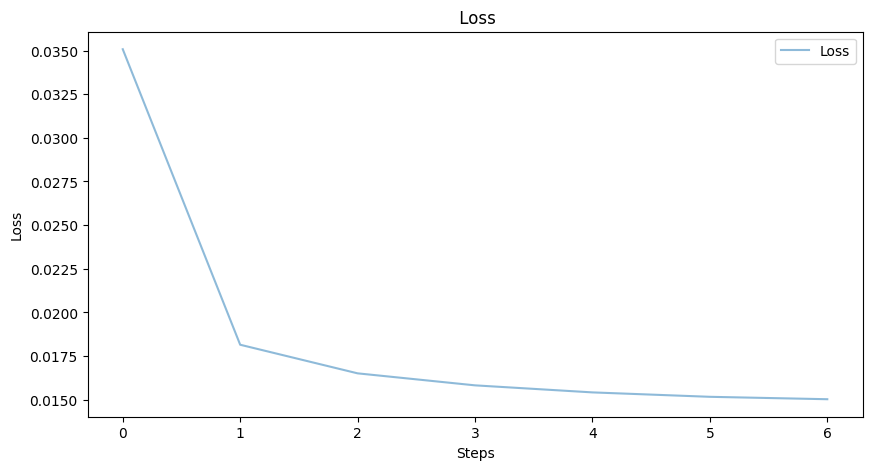

In [46]:
# Plot Loss and Moving Average
losses = []
for metrics in trainer.state.log_history:
    if 'eval_loss' in metrics:
        losses.append(metrics['eval_loss'])
    else:
        losses.append(None)  # Или любое другое значение, которое обозначает отсутствие loss для данного шага

losses = [loss for loss in losses if loss is not None]

steps = np.arange(len(losses))

window_size = 10

plt.figure(figsize=(10, 5))
plt.plot(steps, losses, label="Loss", alpha=0.5)
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title(" Loss")
plt.legend()
plt.show()

In [47]:
# Save the trained model
model.save_pretrained(training_args.output_dir)

print("Training complete.")

Training complete.
